In [ ]:
#  Deep Learning
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
# Machine Learning
from sklearn.model_selection import train_test_split

# other libreries 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Notebook Description

The aim of this code is to *fine tuning* the VGG16 architecture, trained on the imagenet Dataset. 

This is done to classify the type of cancers of our x-ray images.



### Import

In [ ]:
path = '/content/gdrive/MyDrive/DSIM/Focus/'
# creazione del dataset 
x = []
y = []


for dir0 in os.listdir(path):  
  print(dir0,"\n\n") ## MalignFocus / BeningFocus
  if dir0=='MalignFocus':
    classes=0
  else:
     classes=1
  print(classes)
  
  for dir1 in os.listdir(path+dir0):
    print(path+dir0+"/"+dir1,"\n") ## CC/MLO

    for dir2 in os.listdir(path+dir0+"/"+dir1):
        img = image.load_img(path+dir0+"/"+dir1+"/"+dir2, target_size=(224, 224))
        img = image.img_to_array(img)
        x.append(img)
        y.append(classes)

  #cambio valore il maligno è 0 il benigno è 1

  
  # maligno classes = 0 | benigno classes = 1

MalignFocus 


0
/content/gdrive/MyDrive/DSIM/Focus/MalignFocus/MLO 

/content/gdrive/MyDrive/DSIM/Focus/MalignFocus/CC 

BenignFocus 


1
/content/gdrive/MyDrive/DSIM/Focus/BenignFocus/MLO 

/content/gdrive/MyDrive/DSIM/Focus/BenignFocus/CC 



**Comments**: 

The class is perfectyly balanced

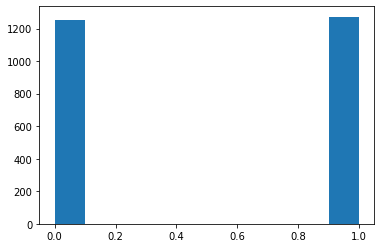

In [ ]:
plt.hist(y);

# **Pre-Processing**

In [ ]:
x = np.array(x)
y = np.array(y)

# suddivisione del dataset in train e validation
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, shuffle=True)

In [ ]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(2022, 224, 224, 3) (2022,) (506, 224, 224, 3) (506,)


#### **Data Augmentation**: 

To properly train the neural network we have done data augmentation. In this way the train data are incremented and the training phase is more robust. 
The main transformation are: 
- zoom
- rotation 
- traslation on the x, y axis

We discard other manipulation such as image flip, because mammographies are "stable" due to the x-ray machine constraint. 

In [ ]:
augm= [0.1, 15, 0.1, 0.1]
train_processing = ImageDataGenerator(preprocessing_function = preprocess_input,            
                             # data augm
                             zoom_range=augm[0],
                             rotation_range=augm[1],
                             width_shift_range=augm[2],
                             height_shift_range=augm[3])
# inizializzazione
train_generator = train_processing.flow(x_train, 
                                        y_train,
                                        batch_size=32,
                                        shuffle=True
                                    )


test_processing = ImageDataGenerator(preprocessing_function = preprocess_input)
# inizializzazione
test_generator = test_processing.flow(x_test, 
                                      y_test,
                                      batch_size=32,
                                      shuffle=True
                   )

### **Fine Tuning**

As stated early, we have chosen the `VGG16` as base model. As summarized in the `model.summary()` the net is taken without the last fully connected layer in order to create our. 


In [ ]:
# our base model
n_outputs = 2
vgg_16_model = VGG16( weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# check if the flag Trainable is false for all the layer of the network.
for layer in vgg_16_model.layers:
    layer.trainable = False
# print the above information
for i, layer in enumerate(vgg_16_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


#### Our FNN

The model created is composed by: 
- `Flatten layer`, to adapt the dimension 
- `Dense layer`, with 1024
  - Activation function: relu
- `Dropout layer` to prevent overfitting
- `Dense layer`, output layer with 1 neuron representing the output class. 
  - Activation function: sigmoid

In [ ]:
x = vgg_16_model.output
x = Flatten()                                 (x) # Flatten dimensions to for use in FC layers
x = Dense(1024, activation='relu')            (x)
x = Dropout(0.5)                              (x) # Dropout layer to reduce overfitting
x = Dense(64, activation='relu')              (x)
x = Dense(1, activation='sigmoid')            (x) # Sigmoid

transfer_model = Model(inputs=vgg_16_model.input, outputs=x)    
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# loss is binary_crossentropy: class bening 1 (True) or 0  (False)
# adam as the optimizer 
# accuracy
# inizialize the model
transfer_model.compile( loss      = 'binary_crossentropy', 
                        optimizer = 'adam', # learning rate
                        metrics   = ['accuracy']
              )

In [ ]:
# start training
history = transfer_model.fit( train_generator,
                              validation_data=test_generator,
                              epochs = 25,
                        ) 

Epoch 1/25
64/64 [==============================] - 28s 379ms/step - loss: 3.0070 - accuracy: 0.5093 - val_loss: 0.6788 - val_accuracy: 0.5810
Epoch 2/25
64/64 [==============================] - 23s 358ms/step - loss: 0.6961 - accuracy: 0.5532 - val_loss: 0.6542 - val_accuracy: 0.6561
Epoch 3/25
64/64 [==============================] - 23s 358ms/step - loss: 0.6626 - accuracy: 0.6073 - val_loss: 0.6272 - val_accuracy: 0.6779
Epoch 4/25
64/64 [==============================] - 23s 359ms/step - loss: 0.6410 - accuracy: 0.6456 - val_loss: 0.6132 - val_accuracy: 0.6818
Epoch 5/25
64/64 [==============================] - 23s 359ms/step - loss: 0.6102 - accuracy: 0.6673 - val_loss: 0.5863 - val_accuracy: 0.6937
Epoch 6/25
64/64 [==============================] - 23s 358ms/step - loss: 0.5843 - accuracy: 0.6850 - val_loss: 0.5667 - val_accuracy: 0.7075
Epoch 7/25
64/64 [==============================] - 23s 358ms/step - loss: 0.5739 - accuracy: 0.7162 - val_loss: 0.5627 - val_accuracy: 0.7154

In [ ]:
# plot model history
def history(history):
  plt.plot(history.history['accuracy'],"blue")
  plt.plot(history.history['val_accuracy'],"red")
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='best')
  plt.show()

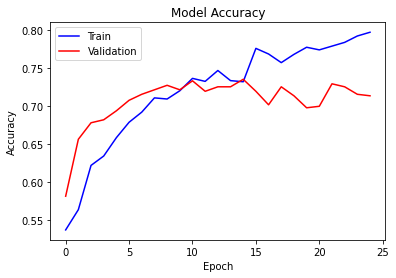

In [ ]:
  history(transfer_model.history)

**Comments:**

The results are acceptable. We have reached a validation accuracy of 0.71%. However some overfitting is still present.

## Demo

In [ ]:
# import image
def preprocess_img(ima):
  display(ima)
  img = image.img_to_array(ima)
  img = np.array(img)
  img = preprocess_input(img)
  print(img.shape)
  img = np.expand_dims(img,0)
  return img

In [ ]:
# predict: threshold 0.5
# if the the value is below the thr => Malign
# else => Benign

def predict(img):
  if transfer_model.predict(img)<0.5:
    print("PREDICTED: MALIGN")
  else: print("PREDICTED: BENIGN")

#### BENIGN SAMPLE

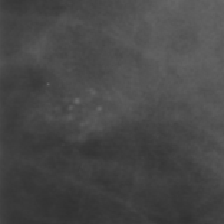

(224, 224, 3)
TRUE LABEL: BENIGN
PREDICTED: BENIGN


In [ ]:
# Focus4171.png benign [V]
# Focus4090.png benign [V]
# Focus4168.png benign [X]

query_1 = image.load_img(path="/content/gdrive/MyDrive/QueryFocus/Benign/CC/Focus4171.png",target_size=(224,224))
img1 = preprocess_img(query_1)
print("TRUE LABEL: BENIGN")
predict(img1)

**Comments:**

As expected the first image is correctly classify. and this is because the net do not find a very contrasted region. 

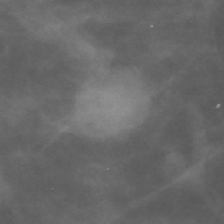

(224, 224, 3)
TRUE LABEL: BENIGN
PREDICTED: BENIGN


In [ ]:
query_1 = image.load_img(path="/content/gdrive/MyDrive/QueryFocus/Benign/CC/Focus4090.png",target_size=(224,224))
img1 = preprocess_img(query_1)#b
print("TRUE LABEL: BENIGN")
predict(img1)

**Comments:**

The second image shows a low contrast region in the middle and again the net correctly classify it. 

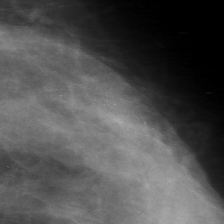

(224, 224, 3)
TRUE LABEL: BENIGN
PREDICTED: MALIGN


In [ ]:
query_1 = image.load_img(path="/content/gdrive/MyDrive/QueryFocus/Benign/CC/Focus4168.png",target_size=(224,224))
img1 = preprocess_img(query_1)#b
print("TRUE LABEL: BENIGN")
predict(img1)

**Comments:**

We have chosen this image to highlight the fact that when the cancer is located at the edge of the breast, we have the focus region partially black. And this lead the model to badly classify the cancer. 

This is probably due to the fact that when high contrasted area are detected, the classifier tends to predict the malign class. 

#### MALIGN SAMPLES

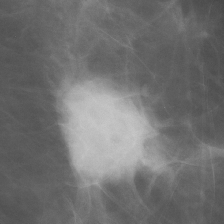

(224, 224, 3)
TRUE LABEL: MALIGN
PREDICTED: MALIGN


In [ ]:
# Focus4178.png [V]
# Focus4181.png [V]
# Focus4161.png [X]

query_2 = image.load_img(path="/content/gdrive/MyDrive/QueryFocus/Malign/CC/Focus4178.png",target_size=(224,224))
img2 = preprocess_img(query_2)#m
print("TRUE LABEL: MALIGN")
predict(img2)

**Comments:**

The fist image shows a high contrast region in the middle and the net is able to correctly classify the cancer. 

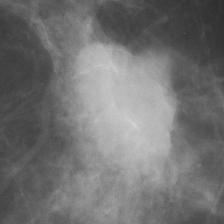

(224, 224, 3)
TRUE LABEL: MALIGN
PREDICTED: MALIGN


In [ ]:
query_2 = image.load_img(path="/content/gdrive/MyDrive/QueryFocus/Malign/CC/Focus4181.png",target_size=(224,224))
img2 = preprocess_img(query_2)#m
print("TRUE LABEL: MALIGN")
predict(img2)

**Comments:**

The second image shows again high contrast region in the middle and the net is still able to correctly classify the cancer. 

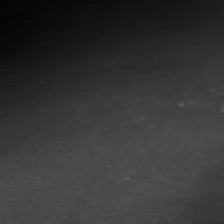

(224, 224, 3)
TRUE LABEL: MALIGN
PREDICTED: BENIGN


In [ ]:
query_2 = image.load_img(path="/content/gdrive/MyDrive/QueryFocus/Malign/CC/Focus4161.png",target_size=(224,224))
img2 = preprocess_img(query_2)#m
print("TRUE LABEL: MALIGN")
predict(img2)

**Comments:**

The third image shows a "flat region" and the net is not able to correctly classify the cancer. 

This partially confirms what we suspect about the behaviour of the Convolutional Neural Network. 

#### Last comments

Eventually the network works fine when the x-ray images are well displayed. Sometimes unfortunatly there are some "critical images", such as: when the cancer is not so evident or the mask display a complete black region where the classifier struggles to recognize the cancer. 

In general we can say that when there are low contrasted area the classifier predicts a benign cancer, and viceversa. 

In [ ]:
## save the model
transfer_model.save('/content/gdrive/MyDrive/DSIM/model_save/')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DSIM/model_save/assets
